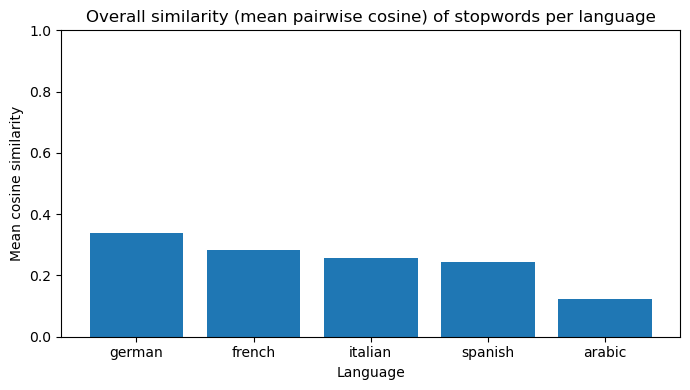

Saved (relative):
- artifacts/spec5_overall_similarity.csv
- artifacts/spec5_overall_similarity.png


In [1]:
# Spec 5: Overall similarity of stopwords per language (average pairwise cosine)
# - Languages: Arabic, French, Spanish, German, Italian
# - Loads fastText models from data/ (bin/vec or gz)
# - For each language: build vectors for stopwords in-vocab, compute mean & std of all pairwise cosine similarities
# - Saves summary CSV + bar plot to artifacts/

import os, gzip, shutil, numpy as np, pandas as pd, matplotlib.pyplot as plt
import nltk

# ---------- paths (work from root or notebooks/) ----------
ART_DIR  = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
DATA_DIR = os.path.abspath("../data"      if os.path.basename(os.getcwd())=="notebooks" else "./data")
os.makedirs(ART_DIR, exist_ok=True); os.makedirs(DATA_DIR, exist_ok=True)

# ---------- NLTK stopwords ----------
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# ---------- language config: NLTK name -> fastText code ----------
LANGS = [
    ("arabic",  "ar"),
    ("french",  "fr"),
    ("spanish", "es"),
    ("german",  "de"),
    ("italian", "it"),
]

# ---------- helpers ----------
def gunzip_once(src_gz, dst):
    """Decompress .gz into dst if needed."""
    if os.path.exists(src_gz) and not os.path.exists(dst):
        with gzip.open(src_gz, 'rb') as f_in, open(dst, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

def load_fasttext_model(lang_code):
    """Load fastText model for a language; supports .bin/.vec and .gz."""
    from gensim.models import KeyedVectors, fasttext as ft_api
    bin_path = os.path.join(DATA_DIR, f"cc.{lang_code}.300.bin")
    vec_path = os.path.join(DATA_DIR, f"cc.{lang_code}.300.vec")
    # try gz
    bin_gz = bin_path + ".gz"; vec_gz = vec_path + ".gz"
    if not os.path.exists(bin_path): gunzip_once(bin_gz, bin_path)
    if not os.path.exists(vec_path): gunzip_once(vec_gz, vec_path)
    # load
    if os.path.exists(bin_path):
        return ft_api.load_facebook_vectors(bin_path)
    if os.path.exists(vec_path):
        return KeyedVectors.load_word2vec_format(vec_path, binary=False)
    return None

def average_pairwise_cosine(V):
    """
    Compute mean and std of cosine similarities for all pairs among rows of V.
    Efficient: normalize rows, use dot-product, take upper triangle (i<j).
    """
    if V.shape[0] < 2:
        return float('nan'), float('nan')
    # normalize rows
    norms = np.linalg.norm(V, axis=1, keepdims=True)
    norms[norms==0] = 1.0
    Vn = V / norms
    S = np.dot(Vn, Vn.T)                 # cosine matrix
    # take upper triangle without diagonal
    iu = np.triu_indices(S.shape[0], k=1)
    vals = S[iu].astype(float)
    return float(np.mean(vals)), float(np.std(vals))

# ---------- main ----------
rows = []

for nltk_name, ft_code in LANGS:
    # stopword list
    try:
        L = sorted(set(stopwords.words(nltk_name)))
    except OSError:
        print(f"[SKIP] No NLTK stopwords for {nltk_name}.")
        continue

    # model
    model = load_fasttext_model(ft_code)
    if model is None:
        print(f"[SKIP] fastText model missing for {ft_code}. Put cc.{ft_code}.300.bin/vec(.gz) in data/.")
        continue

    # words present in model vocab
    vocab_words = [w for w in L if w in model.key_to_index]
    if len(vocab_words) < 2:
        print(f"[SKIP] Not enough in-vocab stopwords for {nltk_name}.")
        continue

    # stack vectors
    V = np.vstack([model.get_vector(w) for w in vocab_words])

    # compute overall similarity: mean/std of all pairwise cosines
    mean_sim, std_sim = average_pairwise_cosine(V)

    rows.append({
        "language": nltk_name,
        "fasttext_code": ft_code,
        "stopwords_total": len(L),
        "in_model": len(vocab_words),
        "overall_similarity_mean": round(mean_sim, 4),
        "overall_similarity_std":  round(std_sim, 4)
    })

# ---------- save summary CSV ----------
df = pd.DataFrame(rows).sort_values("overall_similarity_mean", ascending=False)
out_csv = os.path.join(ART_DIR, "spec5_overall_similarity.csv")
df.to_csv(out_csv, index=False)

# ---------- bar plot ----------
plt.figure(figsize=(7,4))
plt.bar(df["language"], df["overall_similarity_mean"])
plt.ylim(0, 1)
plt.title("Overall similarity (mean pairwise cosine) of stopwords per language")
plt.ylabel("Mean cosine similarity")
plt.xlabel("Language")
plt.tight_layout()
out_png = os.path.join(ART_DIR, "spec5_overall_similarity.png")
plt.savefig(out_png, dpi=150)
plt.show()

# ---------- print relative paths ----------
print("Saved (relative):")
print(f"- artifacts/{os.path.basename(out_csv)}")
print(f"- artifacts/{os.path.basename(out_png)}")
